# Exercise 2: 2-dimensional k-nearest neighbors classifier

In [5]:
# Load data
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

data = pd.read_excel("Rice_Cammeo_Osmancik.xlsx")

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,1.479830,2.004354,2.348547,-0.212943,2.018337,1.499659,-1.152921,Cammeo
1,1.147870,1.125853,0.988390,0.945568,0.410018,1.192918,-0.602079,Cammeo
2,1.135169,1.317214,1.451908,0.253887,1.212956,1.126504,0.405611,Cammeo
3,0.293436,0.115300,0.261439,0.198051,0.239751,0.233857,-0.275351,Cammeo
4,1.166345,1.487053,1.316442,0.523419,0.952221,1.299855,-0.206013,Cammeo


In [11]:
# Normalize quantitative columns to mean 0 and standard deviation 1
cols_to_norm = ["Area", "Perimeter", "Major_Axis_Length", "Minor_Axis_Length", "Eccentricity", "Convex_Area", "Extent"]
data[cols_to_norm] = StandardScaler().fit_transform(data[cols_to_norm])
data.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,1.479830,2.004354,2.348547,-0.212943,2.018337,1.499659,-1.152921,Cammeo
1,1.147870,1.125853,0.988390,0.945568,0.410018,1.192918,-0.602079,Cammeo
2,1.135169,1.317214,1.451908,0.253887,1.212956,1.126504,0.405611,Cammeo
3,0.293436,0.115300,0.261439,0.198051,0.239751,0.233857,-0.275351,Cammeo
4,1.166345,1.487053,1.316442,0.523419,0.952221,1.299855,-0.206013,Cammeo


In [9]:
# Reduce the data to two dimensions using PCA
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
data_reduced = pca.fit_transform(data[cols_to_norm])
pc0 = data_reduced[:, 0]
pc1 = data_reduced[:, 1]
data_pca = pd.DataFrame({"pc0": pc0, "pc1": pc1})

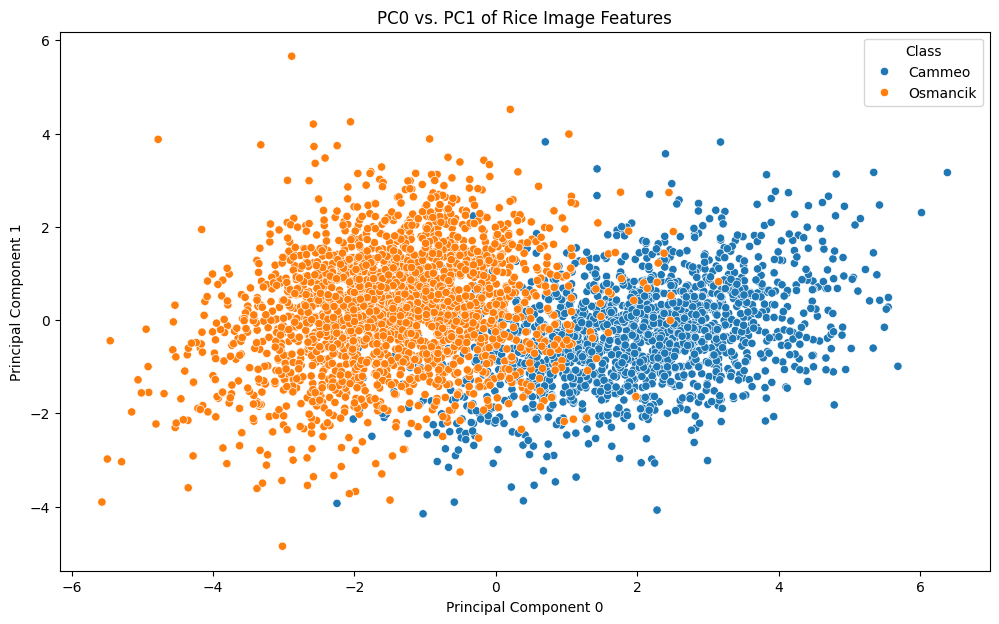

In [13]:
# Generate scatterplot of PC0 vs PC1
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,7))
sns.scatterplot(data = data_pca, x = "pc0", y = "pc1", hue = data["Class"])
plt.title("PC0 vs. PC1 of Rice Image Features")
plt.xlabel("Principal Component 0")
plt.ylabel("Principal Component 1")
plt.show()

**Interpretation:** 

In [ ]:
# 2-dimensional k-nearest neighbors classifier using the Euclidean distance and a quadtree
def knn_quadtree(data, k):
    pass

# Store data (x, y; class) in quadtree
def quadtree(data):
    